In [291]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import xgboost

In [120]:
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

In [2]:
data = pd.read_csv("Telco_customer_churn.csv")
data.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


#### Drop columns with same values in all rows

In [96]:
data.drop(columns=data.columns[data.nunique() == 1], inplace=True)

In [105]:
print(data.dtypes)
x = data.apply(lambda col: col.unique(), axis=0)
print(data.nunique())
print(x)
data.head()
# columns not required: 'CustomerID', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason'

CustomerID            object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object
CustomerID           7043
City                 1129
Zip Code             1652
Lat Long             1652
Latitude    

,CustomerID,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


#### Drop irrelevant columns 

In [118]:
data.drop(columns=['CustomerID', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason'], inplace=True)
data.head()

In [122]:
print(data.dtypes)
print(data.apply(lambda col: col.unique(), axis=0))
# to object: 'Zip Code', 'Latitude', 'Longitude'
# to numeric: 'Total Charges'

City                  object
Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
dtype: object
City                 [Los Angeles, Beverly Hills, Huntington Park, ...
Zip Code             [90003, 90005, 90006, 90010, 90015, 90020, 900...
Latitude             [33.964131, 34.059281, 34.048013, 34.062125, 3...
Longitude            [-118.272783, -118.30742, -118.293953, -118.31...
Gender

#### Change data type

In [127]:
data[['Zip Code', 'Latitude', 'Longitude']] = data[['Zip Code', 'Latitude', 'Longitude']].astype('object')
# pd.to_numeric(data['Total Charges']) -- gives error because this column has " "
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')

#### Checking suspicion that Zip Code and Lat/Long columns are highly correlated

In [132]:
print(data.groupby(['Zip Code', 'Latitude', 'Longitude']).size())

In [166]:
# data['Lat Long'] = data['Latitude'].astype('str') + data['Longitude'].astype('str')
# data['Lat Long'].nunique()

In [172]:
from scipy.stats import chi2_contingency
CrosstabResult = pd.crosstab(index=data['Lat Long'] ,columns=data['Zip Code'])

In [183]:
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
# P value of 0 indicates that we can reject null hypothesis that the two variables are correlated

The P-Value of the ChiSq Test is: 0.0


In [184]:
data.drop(columns=['Lat Long', 'Latitude', 'Longitude'], inplace=True)
data.head()

In [189]:
# label encoding for dependent variable
data['Churn Label'] = data['Churn Label'].replace({'Yes':1, 'No':0})

In [190]:
data['Churn Label'].unique()

array([1, 0], dtype=int64)

In [191]:
print(data.dtypes)
print(data.apply(lambda col: col.unique(), axis=0))

City                  object
Zip Code              object
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Label            int64
dtype: object
City                 [Los Angeles, Beverly Hills, Huntington Park, ...
Zip Code             [90003, 90005, 90006, 90010, 90015, 90020, 900...
Gender                                                  [Male, Female]
Senior Citizen                                               [No, Yes]
Partner                                                      [No

In [198]:
# Total Charges has NAs that needs to be replaced.
print(data.isna().sum())
# Total Charges is blank for customers with tenure as 0. Since, they are new Customers, we can replace blanks with 0.
data[data['Total Charges'].isna()]

City                  0
Zip Code              0
Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Label           0
dtype: int64


,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
2234,San Bernardino,92408,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
2438,Independence,93526,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
2568,San Mateo,94401,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
2667,Cupertino,95014,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
2856,Redcrest,95569,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
4331,Los Angeles,90029,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
4687,Sun City,92585,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
5104,Ben Lomond,95005,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5719,La Verne,91750,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6772,Bell,90201,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


In [200]:
data['Total Charges'][data['Total Charges'].isna()] = 0

<ipython-input-200-8e770288bf0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Total Charges'][data['Total Charges'].isna()] = 0


In [201]:
# Checking na count after imputation
print(data.isna().sum())

City                 0
Zip Code             0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Label          0
dtype: int64


In [205]:
# below steps are done so that the tree that we make at the end is legible
# replacing blank spaces in column names with '_'
data.columns = data.columns.str.replace(' ','_')
# replacing blank spaces in data with '_'
data.replace(' ','_', regex = True, inplace = True)
data.head()

,City,Zip_Code,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label
0,Los_Angeles,90003,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


In [213]:
print(data.dtypes)
# Zip_code is still int. change it to object
data['Zip_Code'] = data['Zip_Code'].astype('object')
catCols = data.select_dtypes(include='object').columns
numCols = data.select_dtypes(include='number').columns
print(catCols)
print(numCols)
print(data.dtypes)

City                  object
Zip_Code              object
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Label            int64
dtype: object
Index(['City', 'Zip_Code', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method'],
      dtype='object')
In

In [225]:
CrosstabResult_1 = pd.crosstab(index=data['City'] ,columns=data['Zip_Code'])
ChiSqResult_1 = chi2_contingency(CrosstabResult_1)
print('The P-Value of the ChiSq Test is:', ChiSqResult_1[1])
# P value of 0 indicates that we can reject null hypothesis that the two variables are correlated

The P-Value of the ChiSq Test is: 0.0


In [226]:
# dropping zip code column
data.drop(columns=['Zip_Code'], inplace=True)

In [228]:
catCols = data.select_dtypes(include='object').columns
numCols = data.select_dtypes(include='number').columns
print(catCols)
print(numCols)

Index(['City', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method'],
      dtype='object')
Index(['Tenure_Months', 'Monthly_Charges', 'Total_Charges', 'Churn_Label'], dtype='object')


In [229]:
# one hot encoding for categorical columns
data_encoded = pd.get_dummies(data, columns=catCols)

In [230]:
print(data_encoded.shape)
data_encoded.head()

(7043, 1176)


,Tenure_Months,Monthly_Charges,Total_Charges,Churn_Label,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador_City,City_Amboy,City_Anaheim,City_Anderson,City_Angels_Camp,City_Angelus_Oaks,City_Angwin,City_Annapolis,City_Antelope,City_Antioch,City_Anza,City_Apple_Valley,City_Applegate,City_Aptos,City_Arbuckle,City_Arcadia,City_Arcata,City_Armona,City_Arnold,City_Aromas,City_Arroyo_Grande,City_Artesia,City_Arvin,City_Atascadero,City_Atherton,City_Atwater,City_Auberry,City_Auburn,City_Avalon,City_Avenal,City_Avery,City_Avila_Beach,City_Azusa,City_Badger,City_Baker,City_Bakersfield,City_Baldwin_Park,City_Ballico,City_Bangor,City_Banning,City_Barstow,City_Bass_Lake,City_Bayside,City_Beale_Afb,City_Beaumont,City_Bell,City_Bella_Vista,City_Bellflower,City_Belmont,City_Belvedere_Tiburon,City_Ben_Lomond,City_Benicia,City_Benton,City_Berkeley,City_Berry_Creek,City_Bethel_Island,City_Beverly_Hills,City_Bieber,City_Big_Bar,City_Big_Bear_City,City_Big_Bear_Lake,City_Big_Bend,City_Big_Creek,City_Big_Oak_Flat,City_Big_Pine,City_Big_Sur,City_Biggs,City_Biola,City_Birds_Landing,City_Bishop,City_Blairsden_Graeagle,City_Blocksburg,City_Bloomington,City_Blue_Lake,City_Blythe,City_Bodega,City_Bodega_Bay,City_Bodfish,City_Bolinas,City_Bonita,City_Bonsall,City_Boonville,City_Boron,City_Borrego_Springs,City_Boulder_Creek,City_Boulevard,City_Bradley,City_Branscomb,City_Brawley,City_Brea,City_Brentwood,City_Bridgeport,City_Bridgeville,City_Brisbane,City_Brookdale,City_Brooks,City_Browns_Valley,City_Brownsville,City_Buellton,City_Buena_Park,City_Burbank,City_Burlingame,City_Burney,City_Burnt_Ranch,City_Burson,City_Butte_City,City_Buttonwillow,City_Byron,City_Cabazon,City_Calabasas,City_Calexico,City_Caliente,City_California_City,City_California_Hot_Springs,City_Calimesa,City_Calipatria,City_Calistoga,City_Callahan,City_Calpine,City_Camarillo,City_Cambria,City_Camino,City_Camp_Nelson,City_Campbell,City_Campo,City_Campo_Seco,City_Camptonville,City_Canby,City_Canoga_Park,City_Cantua_Creek,City_Canyon_Country,City_Canyon_Dam,City_Capay,City_Capistrano_Beach,City_Capitola,City_Cardiff_By_The_Sea,City_Carlotta,City_Carlsbad,City_Carmel,City_Carmel_By_The_Sea,City_Carmel_Valley,City_Carmichael,City_Carnelian_Bay,City_Carpinteria,City_Carson,City_Caruthers,City_Casmalia,City_Caspar,City_Cassel,City_Castaic,City_Castella,City_Castro_Valley,City_Castroville,City_Cathedral_City,City_Catheys_Valley,City_Cayucos,City_Cazadero,City_Cedar_Glen,City_Cedarville,City_Ceres,City_Cerritos,City_Challenge,City_Chatsworth,City_Chester,City_Chico,City_Chilcoot,City_Chino,City_Chino_Hills,City_Chowchilla,City_Chualar,City_Chula_Vista,City_Citrus_Heights,City_Claremont,City_Clarksburg,City_Clayton,City_Clearlake,City_Clearlake_Oaks,City_Clements,City_Clio,City_Clipper_Mills,City_Cloverdale,City_Clovis,City_Coachella,City_Coalinga,City_Coarsegold,City_Cobb,City_Coleville,City_Colfax,City_Colton,City_Columbia,City_Colusa,City_Comptche,City_Compton,City_Concord,City_Cool,City_Copperopolis,City_Corcoran,City_Corning,City_Corona,City_Corona_Del_Mar,City_Coronado,City_Corte_Madera,City_Costa_Mesa,City_Cotati,City_Cottonwood,City_Coulterville,City_Courtland,City_Covelo,City_Covina,City_Crescent_City,City_Crescent_Mills,City_Cressey,City_Crestline,City_Creston,City_Crockett,City_Crows_Landing,City_Culver_City,City_Cupertino,City_Cutler,City_Cypress,City_Daggett,City_Daly_City,City_Dana_Point,City_Danville,City_Darwin,City_Davenport,City_Davis,City_Davis_Creek,City_Death_Valley,City_Deer_Park,City_Del_Mar,City_Del_Rey,City_Delano,City_Delhi,City_Denair,City_Descanso,City_Desert_Center,City_Desert_Hot_Springs,City_Diamond_Bar,City_Diamond_Springs,City_Dillon_Beach,City_Dinuba,City_Dixon,City_Dobbins,City_Dorris,City_Dos_Palos,City_Dos_Rios,City_Douglas_City,

In [236]:
y = data_encoded['Churn_Label']
X = pd.DataFrame(data_encoded.drop(columns=['Churn_Label']))

In [239]:
print(y.unique())
print(sum(y)/len(y))
X.head()

[1 0]
0.2653698707936959


,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador_City,City_Amboy,City_Anaheim,City_Anderson,City_Angels_Camp,City_Angelus_Oaks,City_Angwin,City_Annapolis,City_Antelope,City_Antioch,City_Anza,City_Apple_Valley,City_Applegate,City_Aptos,City_Arbuckle,City_Arcadia,City_Arcata,City_Armona,City_Arnold,City_Aromas,City_Arroyo_Grande,City_Artesia,City_Arvin,City_Atascadero,City_Atherton,City_Atwater,City_Auberry,City_Auburn,City_Avalon,City_Avenal,City_Avery,City_Avila_Beach,City_Azusa,City_Badger,City_Baker,City_Bakersfield,City_Baldwin_Park,City_Ballico,City_Bangor,City_Banning,City_Barstow,City_Bass_Lake,City_Bayside,City_Beale_Afb,City_Beaumont,City_Bell,City_Bella_Vista,City_Bellflower,City_Belmont,City_Belvedere_Tiburon,City_Ben_Lomond,City_Benicia,City_Benton,City_Berkeley,City_Berry_Creek,City_Bethel_Island,City_Beverly_Hills,City_Bieber,City_Big_Bar,City_Big_Bear_City,City_Big_Bear_Lake,City_Big_Bend,City_Big_Creek,City_Big_Oak_Flat,City_Big_Pine,City_Big_Sur,City_Biggs,City_Biola,City_Birds_Landing,City_Bishop,City_Blairsden_Graeagle,City_Blocksburg,City_Bloomington,City_Blue_Lake,City_Blythe,City_Bodega,City_Bodega_Bay,City_Bodfish,City_Bolinas,City_Bonita,City_Bonsall,City_Boonville,City_Boron,City_Borrego_Springs,City_Boulder_Creek,City_Boulevard,City_Bradley,City_Branscomb,City_Brawley,City_Brea,City_Brentwood,City_Bridgeport,City_Bridgeville,City_Brisbane,City_Brookdale,City_Brooks,City_Browns_Valley,City_Brownsville,City_Buellton,City_Buena_Park,City_Burbank,City_Burlingame,City_Burney,City_Burnt_Ranch,City_Burson,City_Butte_City,City_Buttonwillow,City_Byron,City_Cabazon,City_Calabasas,City_Calexico,City_Caliente,City_California_City,City_California_Hot_Springs,City_Calimesa,City_Calipatria,City_Calistoga,City_Callahan,City_Calpine,City_Camarillo,City_Cambria,City_Camino,City_Camp_Nelson,City_Campbell,City_Campo,City_Campo_Seco,City_Camptonville,City_Canby,City_Canoga_Park,City_Cantua_Creek,City_Canyon_Country,City_Canyon_Dam,City_Capay,City_Capistrano_Beach,City_Capitola,City_Cardiff_By_The_Sea,City_Carlotta,City_Carlsbad,City_Carmel,City_Carmel_By_The_Sea,City_Carmel_Valley,City_Carmichael,City_Carnelian_Bay,City_Carpinteria,City_Carson,City_Caruthers,City_Casmalia,City_Caspar,City_Cassel,City_Castaic,City_Castella,City_Castro_Valley,City_Castroville,City_Cathedral_City,City_Catheys_Valley,City_Cayucos,City_Cazadero,City_Cedar_Glen,City_Cedarville,City_Ceres,City_Cerritos,City_Challenge,City_Chatsworth,City_Chester,City_Chico,City_Chilcoot,City_Chino,City_Chino_Hills,City_Chowchilla,City_Chualar,City_Chula_Vista,City_Citrus_Heights,City_Claremont,City_Clarksburg,City_Clayton,City_Clearlake,City_Clearlake_Oaks,City_Clements,City_Clio,City_Clipper_Mills,City_Cloverdale,City_Clovis,City_Coachella,City_Coalinga,City_Coarsegold,City_Cobb,City_Coleville,City_Colfax,City_Colton,City_Columbia,City_Colusa,City_Comptche,City_Compton,City_Concord,City_Cool,City_Copperopolis,City_Corcoran,City_Corning,City_Corona,City_Corona_Del_Mar,City_Coronado,City_Corte_Madera,City_Costa_Mesa,City_Cotati,City_Cottonwood,City_Coulterville,City_Courtland,City_Covelo,City_Covina,City_Crescent_City,City_Crescent_Mills,City_Cressey,City_Crestline,City_Creston,City_Crockett,City_Crows_Landing,City_Culver_City,City_Cupertino,City_Cutler,City_Cypress,City_Daggett,City_Daly_City,City_Dana_Point,City_Danville,City_Darwin,City_Davenport,City_Davis,City_Davis_Creek,City_Death_Valley,City_Deer_Park,City_Del_Mar,City_Del_Rey,City_Delano,City_Delhi,City_Denair,City_Descanso,City_Desert_Center,City_Desert_Hot_Springs,City_Diamond_Bar,City_Diamond_Springs,City_Dillon_Beach,City_Dinuba,City_Dixon,City_Dobbins,City_Dorris,City_Dos_Palos,City_Dos_Rios,City_Douglas_City,City_Downey,

In [240]:
# data is slightly imbalanced as we only of 26% of 1 class. 
# Hence, using stratify = y so that the train test split also happens in the same ratio of dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [246]:
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))
print(type(y_train))
y_train.dtypes

0.2653532126375577
0.2654364797728886
<class 'pandas.core.series.Series'>


dtype('int64')

In [255]:
# removed missing = None from XGBClassifier method because getting error while predicting
xgb = XGBClassifier(objective='binary:logistic', seed = 42)
xgb.fit(X_train, 
        y_train,
        #use_label_encoder=False,
        verbose = True, # prints the progress of xgb fit
        early_stopping_rounds = 10, # to stop building trees if the situation doesnt improve in the last 10 rounds
        eval_metric = 'aucpr',
        eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.61905
[1]	validation_0-aucpr:0.64978
[2]	validation_0-aucpr:0.65810
[3]	validation_0-aucpr:0.65782
[4]	validation_0-aucpr:0.65817
[5]	validation_0-aucpr:0.66217
[6]	validation_0-aucpr:0.66236
[7]	validation_0-aucpr:0.66211
[8]	validation_0-aucpr:0.66490
[9]	validation_0-aucpr:0.66768
[10]	validation_0-aucpr:0.67112
[11]	validation_0-aucpr:0.67276
[12]	validation_0-aucpr:0.67279
[13]	validation_0-aucpr:0.67271
[14]	validation_0-aucpr:0.67238
[15]	validation_0-aucpr:0.67281
[16]	validation_0-aucpr:0.67148
[17]	validation_0-aucpr:0.67149
[18]	validation_0-aucpr:0.67069
[19]	validation_0-aucpr:0.67213
[20]	validation_0-aucpr:0.67108
[21]	validation_0-aucpr:0.67353
[22]	validation_0-aucpr:0.67259
[23]	validation_0-aucpr:0.67264
[24]	validation_0-aucpr:0.67139
[25]	validation_0-aucpr:0.67121
[26]	validation_0-aucpr:0.67081
[27]	validation_0-aucpr:0.67081
[28]	validation_0-aucpr:0.67158
[29]	validation_0-aucpr:0.66936
[30]	validation_0-aucpr:0.66934


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



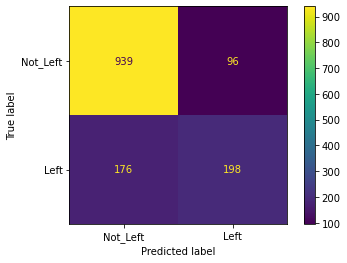

In [265]:
y_pred = xgb.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb, X_test, y_test, values_format='d', display_labels=['Not_Left', 'Left'])
print(classification_report(y_test, y_pred))

In [277]:
# Optimize parameters using cross validation
# According to xgboost documentation, for imbalanced data: Balance +ve and -ve wwights via scale_pos_weight, Use AOC for evaluation
## Round 1:
# param_grid = {
#     'max_depth':[3,4,5],
#     'learning_rate':[0.1,0.01,0.05],
#     'gamma':[0,0.25,0.5],
#     'reg_lambda':[0,1.0,10.0],
#     'scale_pos_weight':[1,3,5]
# }
# 1st Round result: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}
## Round 2:
param_grid = {
    'max_depth':[4],
    'learning_rate':[0.1, 0.25, 0.5],
    'gamma':[0.25],
    'reg_lambda':[10.0, 20.0, 50.0],
    'scale_pos_weight':[1,3,5]
}

optimal_params = GridSearchCV(estimator=XGBClassifier(objective = 'binary:logistic', 
                                                      seed = 42, 
                                                      subsample=0.9, 
                                                      colsample_bytree = 0.5),
                              param_grid=param_grid,
                              scoring='roc_auc',
                              verbose = 0,
                              n_jobs = 10,
                              cv = 3)

In [278]:
optimal_params.fit(X_train, 
                   y_train, 
                   early_stopping_rounds = 10, 
                   eval_metric = 'auc',
                   eval_set = [(X_test, y_test)],
                   verbose = False)

print(optimal_params.best_params_)
# 1st Round result: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}
# 2nd Round result: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}
# scale_pos_weight represents the ratio of number of negative class to the positive class. 
# Since here we have the ratio of 3, but using gridsearch we are getting a value of 1. 
# We will try both values and check accuracy.

C:\Users\Siddharth_Malani\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


[15:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "learn_rate" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.59874
[1]	validation_0-aucpr:0.59892
[2]	validation_0-aucpr:0.60823
[3]	validation_0-aucpr:0.60911
[4]	validation_0-aucpr:0.63377
[5]	validation_0-aucpr:0.63892
[6]	validation_0-aucpr:0.64995
[7]	validation_0-aucpr:0.65236
[8]	validation_0-aucpr:0.65461
[9]	validation_0-aucpr:0.65468
[10]	validation_0-aucpr:0.65686
[11]	validation_0-aucpr:0.65820
[12]	validation_0-aucpr:0.65885
[13]	validation_0-aucpr:0.65954
[14]	validation_0-aucpr:0.66048
[15]	validation_0-aucpr:0.66211
[16]	validation_0-aucpr:0.66375
[17]	validation_0-aucpr:0.66531
[18]	validation_0-aucpr:0.66522
[19]	validat

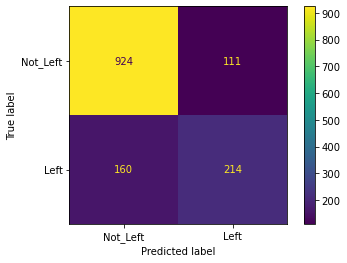

In [283]:
xgb = XGBClassifier(objective='binary:logistic', 
                    seed = 42, 
                    gamma = 0.25, 
                    learn_rate = 0.1, 
                    max_depth = 4, 
                    reg_lambda = 10, 
                    scale_pos_weight = 1, 
                    colsample_bytree = 0.5)
xgb.fit(X_train, 
        y_train,
        #use_label_encoder=False,
        verbose = True, # prints the progress of xgb fit
        early_stopping_rounds = 10, # to stop building trees if the situation doesnt improve in the last 10 rounds
        eval_metric = 'aucpr',
        eval_set = [(X_test, y_test)])

plot_confusion_matrix(xgb, X_test, y_test, values_format='d', display_labels=['Not_Left', 'Left'])
print(classification_report(y_test, xgb.predict(X_test)))
# with scale_pos_weight =3, our accuracy for 

[15:45:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "learn_rate" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.60485
[1]	validation_0-aucpr:0.59850
[2]	validation_0-aucpr:0.61026
[3]	validation_0-aucpr:0.61036
[4]	validation_0-aucpr:0.63286
[5]	validation_0-aucpr:0.63634
[6]	validation_0-aucpr:0.64583
[7]	validation_0-aucpr:0.65325
[8]	validation_0-aucpr:0.66333
[9]	validation_0-aucpr:0.66629
[10]	validation_0-aucpr:0.66627
[11]	validation_0-aucpr:0.66635
[12]	validation_0-aucpr:0.67143
[13]	validation_0-aucpr:0.67134
[14]	validation_0-aucpr:0.67327
[15]	validation_0-aucpr:0.67595
[16]	validation_0-aucpr:0.67827
[17]	validation_0-aucpr:0.68007
[18]	validation_0-aucpr:0.67979
[19]	validat

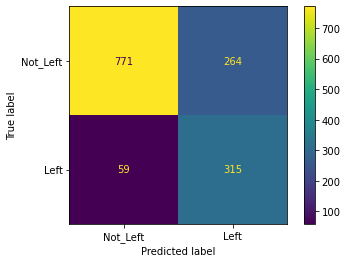

In [284]:
xgb = XGBClassifier(objective='binary:logistic', 
                    seed = 42, 
                    gamma = 0.25, 
                    learn_rate = 0.1, 
                    max_depth = 4, 
                    reg_lambda = 10, 
                    scale_pos_weight = 3, 
                    colsample_bytree = 0.5)
xgb.fit(X_train, 
        y_train,
        #use_label_encoder=False,
        verbose = True, # prints the progress of xgb fit
        early_stopping_rounds = 10, # to stop building trees if the situation doesnt improve in the last 10 rounds
        eval_metric = 'aucpr',
        eval_set = [(X_test, y_test)])

plot_confusion_matrix(xgb, X_test, y_test, values_format='d', display_labels=['Not_Left', 'Left'])
print(classification_report(y_test, xgb.predict(X_test)))
# with scale_pos_weight =3, our accuracy for customers who left the company improves significantly. Hence, final value is 3.

In [286]:
xgb = XGBClassifier(objective='binary:logistic', 
                    seed = 42, 
                    gamma = 0.25, 
                    learn_rate = 0.1, 
                    max_depth = 4, 
                    reg_lambda = 10, 
                    scale_pos_weight = 3, 
                    colsample_bytree = 0.5, 
                    n_estimators = 1)
xgb.fit(X_train, y_train)

[15:48:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "learn_rate" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:48:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.1, learning_rate=0.300000012, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=42, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [295]:
bst = xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' %importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape':'box', 
               'style': 'filled, rounded', 
               'fillcolor': '#78cbe'}
leaf_params = {'shape':'box', 
               'style': 'filled', 
               'fillcolor': '#e48038'}
xgboost.to_graphviz(xgb, num_trees = 0, size = "10,10", 
                condition_node_params = node_params, 
                leaf_node_params = leaf_params)

weight:  {'Online_Security_No': 1, 'Tenure_Months': 4, 'Internet_Service_Fiber_optic': 2, 'Monthly_Charges': 1, 'Senior_Citizen_Yes': 1, 'Internet_Service_DSL': 2, 'Dependents_No': 2, 'Total_Charges': 1, 'Partner_No': 1}
gain:  {'Online_Security_No': 1337.6709, 'Tenure_Months': 192.083725025, 'Internet_Service_Fiber_optic': 97.79431905, 'Monthly_Charges': 7.93931961, 'Senior_Citizen_Yes': 6.36102295, 'Internet_Service_DSL': 109.22589134999998, 'Dependents_No': 111.6707765, 'Total_Charges': 55.8566742, 'Partner_No': 4.41525269}
cover:  {'Online_Security_No': 2156.0, 'Tenure_Months': 652.0625, 'Internet_Service_Fiber_optic': 439.5, 'Monthly_Charges': 60.5, 'Senior_Citizen_Yes': 366.25, 'Internet_Service_DSL': 602.5, 'Dependents_No': 519.5, 'Total_Charges': 238.0, 'Partner_No': 72.0}
total_gain:  {'Online_Security_No': 1337.6709, 'Tenure_Months': 768.3349001, 'Internet_Service_Fiber_optic': 195.5886381, 'Monthly_Charges': 7.93931961, 'Senior_Citizen_Yes': 6.36102295, 'Internet_Service_DSL

ImportError: You must install graphviz to plot tree

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
logReg = LogisticRegression()
logReg.fit(X_train.iloc[:,1:], y_train)
y_pred_logReg = logReg.predict(X_test.iloc[:,1:])
print(confusion_matrix(y_test, y_pred_logReg))
print(classification_report(y_test, y_pred_logReg))

[[936 105]
 [177 191]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1041
           1       0.65      0.52      0.58       368

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [121]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
rf = RandomForestClassifier()
rf.fit(X_train.iloc[:,1:], y_train)
y_pred_rf = rf.predict(X_test.iloc[:,1:])
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[922 119]
 [198 170]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1041
           1       0.59      0.46      0.52       368

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.69      1409
weighted avg       0.76      0.78      0.77      1409

